# 02_Model_Dev: Model Development

This notebook develops the forecasting model for Oddbox’s weekly box demand, based on the EDA insights and modular architecture defined earlier.

Our approach decomposes total demand into interpretable and modular components — each aligned to business logic and real-world drivers like subscribers, promotions, and seasonal effects. We intentionally avoid black-box monoliths and instead opt for a stack of smaller, explainable models.

---

## Notebook Purpose

- Implement the **layered forecasting framework**:
  1. Subscriber projection
  2. Box type demand share modeling
  3. Adjustment for marketing and holidays
- Engineer time-aware and domain-driven features
- Train a main model (e.g., LightGBM or XGBoost) with baselines for comparison
- Add stretch layer for uncertainty-aware predictions (quantiles or bootstraps)
- Output clean forecasts for each box type over the next 4 weeks

---

## Notebook Structure

### 5. Adjustment Layer
- Apply uplift factors for marketing and holiday weeks
- Compare pre- and post-adjustment forecasts

### 6. Forecast Generation
- Predict next 4 weeks for each box type
- Include confidence intervals or quantiles if possible

### 7. Output & Visualisation
- Save to `forecast.csv`
- Generate visual plots: Actual vs Predicted with confidence bands

---

## Core Assumptions

- Short-horizon subscriber counts are predictable with autoregressive logic
- Box type preferences are stable and separable from total volume
- Promotions and holidays have measurable, quantifiable impacts
- Engineered features can compensate for data sparsity and noise

## 1. Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import importlib

# Model libraries
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
import lightgbm as lgb

# Custom modules
from oddbox_forecasting import (
    config, 
    pipeline
)
importlib.reload(pipeline)

# Display settings
pd.set_option("display.max_columns", None)

In [2]:
# Directories
raw_path = Path("../data/raw/data.csv")
processed_dir = Path("../data/processed")
processed_dir.mkdir(parents=True, exist_ok=True)

# Load latest processed file or generate it if none exists
processed_files = sorted(processed_dir.glob("*_processed.csv"))

if processed_files:
    latest_file = processed_files[-1]
    print(f"Loading existing processed file: {latest_file.name}")
    df = pd.read_csv(latest_file)
else:
    print("No processed file found. Running pipeline...")
    df = pipeline.load_and_prepare(raw_path)

df.head()

Loading existing processed file: 20250616_104130_processed.csv


,week,box_type,box_orders,is_marketing_week,holiday_week,weekly_subscribers,fortnightly_subscribers,weekly_subscribers_lag_1,weekly_subscribers_lag_2,box_orders_lag_1,box_orders_lag_2,box_orders_rollmean,box_orders_rollstd,is_event_week,weekofyear,week_sin,week_cos,marketing_x_box,holiday_x_box,box_orders_volatility
0,2024-04-15,LFV,79,0,0,483,167.0,NaN,NaN,NaN,NaN,NaN,NaN,0,16,0.935016,-0.354605,LFV_MKT_0,LFV_HOL_0,NaN
1,2024-04-15,LV,79,0,0,483,167.0,NaN,NaN,NaN,NaN,NaN,NaN,0,16,0.935016,-0.354605,LV_MKT_0,LV_HOL_0,NaN
2,2024-04-15,MFV,84,0,0,483,167.0,NaN,NaN,NaN,NaN,NaN,NaN,0,16,0.935016,-0.354605,MFV_MKT_0,MFV_HOL_0,NaN
3,2024-04-15,MV,78,0,0,483,167.0,NaN,NaN,NaN,NaN,NaN,NaN,0,16,0.935016,-0.354605,MV_MKT_0,MV_HOL_0,NaN
4,2024-04-15,SFV,82,0,0,483,167.0,NaN,NaN,NaN,NaN,NaN,NaN,0,16,0.935016,-0.354605,SFV_MKT_0,SFV_HOL_0,NaN


## 2. Feature Preparation
We prepare the dataset for a range of modelling tasks:

- **Baseline Forecasts**: Require simple historical aggregation (e.g., mean, seasonal naïve)
- **ML Models**: Use engineered features with LightGBM/XGBoost per box type
- **Adjustments**: Need marketing and holiday week flags for post-hoc uplift modeling
- **Forecasting**: Prepare the final dataset structure to support rolling forecasts

In [3]:
# Drop rows with NaNs (from lag/rolling features)
df_model = df.dropna().copy()
print(f"Rows after dropping NaNs: {len(df_model)}")

# Define target
target_col = "box_orders"

# Core features for ML models
feature_cols = [
    # Subscriber signals
    "weekly_subscribers",
    "fortnightly_subscribers",
    "weekly_subscribers_lag_1",
    "weekly_subscribers_lag_2",
    
    # Box order history
    "box_orders_lag_1",
    "box_orders_lag_2",
    "box_orders_rollmean",
    "box_orders_rollstd",
    "box_orders_volatility",
    
    # Time-based signals
    "week_sin",
    "week_cos",
    
    # Event flags
    "is_marketing_week",
    "holiday_week",
    "is_event_week",
    
    # Interaction (for later use in adjustment layers)
    "marketing_x_box",
    "holiday_x_box",
]

# Confirm features are present
missing = [f for f in feature_cols if f not in df_model.columns]
assert not missing, f"Missing expected features: {missing}"

# Subset feature matrix and target
X_all = df_model[feature_cols].copy()
y_all = df_model[target_col].copy()

print(f"X_all shape: {X_all.shape}")
print(f"y_all shape: {y_all.shape}")

# Store per-box-type slices (for ML or baseline modeling later)
box_type_dfs = {
    box: group.dropna(subset=feature_cols + [target_col])
    for box, group in df_model.groupby("box_type")
}
df_model.head()

Rows after dropping NaNs: 400
X_all shape: (400, 16)
y_all shape: (400,)


,week,box_type,box_orders,is_marketing_week,holiday_week,weekly_subscribers,fortnightly_subscribers,weekly_subscribers_lag_1,weekly_subscribers_lag_2,box_orders_lag_1,box_orders_lag_2,box_orders_rollmean,box_orders_rollstd,is_event_week,weekofyear,week_sin,week_cos,marketing_x_box,holiday_x_box,box_orders_volatility
16,2024-04-29,LFV,97,0,0,501,173.0,453.0,483.0,64.0,79.0,80.000000,16.522712,0,18,0.822984,-0.568065,LFV_MKT_0,LFV_HOL_0,16.522712
17,2024-04-29,LV,91,0,0,501,173.0,453.0,483.0,83.0,79.0,84.333333,6.110101,0,18,0.822984,-0.568065,LV_MKT_0,LV_HOL_0,6.110101
18,2024-04-29,MFV,79,0,0,501,173.0,453.0,483.0,82.0,84.0,81.666667,2.516611,0,18,0.822984,-0.568065,MFV_MKT_0,MFV_HOL_0,2.516611
19,2024-04-29,MV,81,0,0,501,173.0,453.0,483.0,75.0,78.0,78.000000,3.000000,0,18,0.822984,-0.568065,MV_MKT_0,MV_HOL_0,3.000000
20,2024-04-29,SFV,76,0,0,501,173.0,453.0,483.0,73.0,82.0,77.000000,4.582576,0,18,0.822984,-0.568065,SFV_MKT_0,SFV_HOL_0,4.582576


## 3. Baseline Forecasts
We begin with two simple baselines to set reference performance levels for our forecasting models.

#### 1. Rolling Average (Last 3 Weeks)
- **Method**: Uses the mean of the previous 3 weeks' box_orders to forecast the next 4 weeks.
- **Why it works**: Captures local trends and noise smoothing. Especially useful when demand is stable but not highly seasonal.
- **Weakness**: Fails to account for seasonality or known demand dips (e.g., holidays).

#### 2. Seasonal Naïve
- **Method**: Repeats the same value from the same week(s) last year.
- **Why it works**: Effective if demand follows a strong yearly seasonal pattern.
- **Limitations**: Requires a full year of history to operate; may fall back to rolling average otherwise.

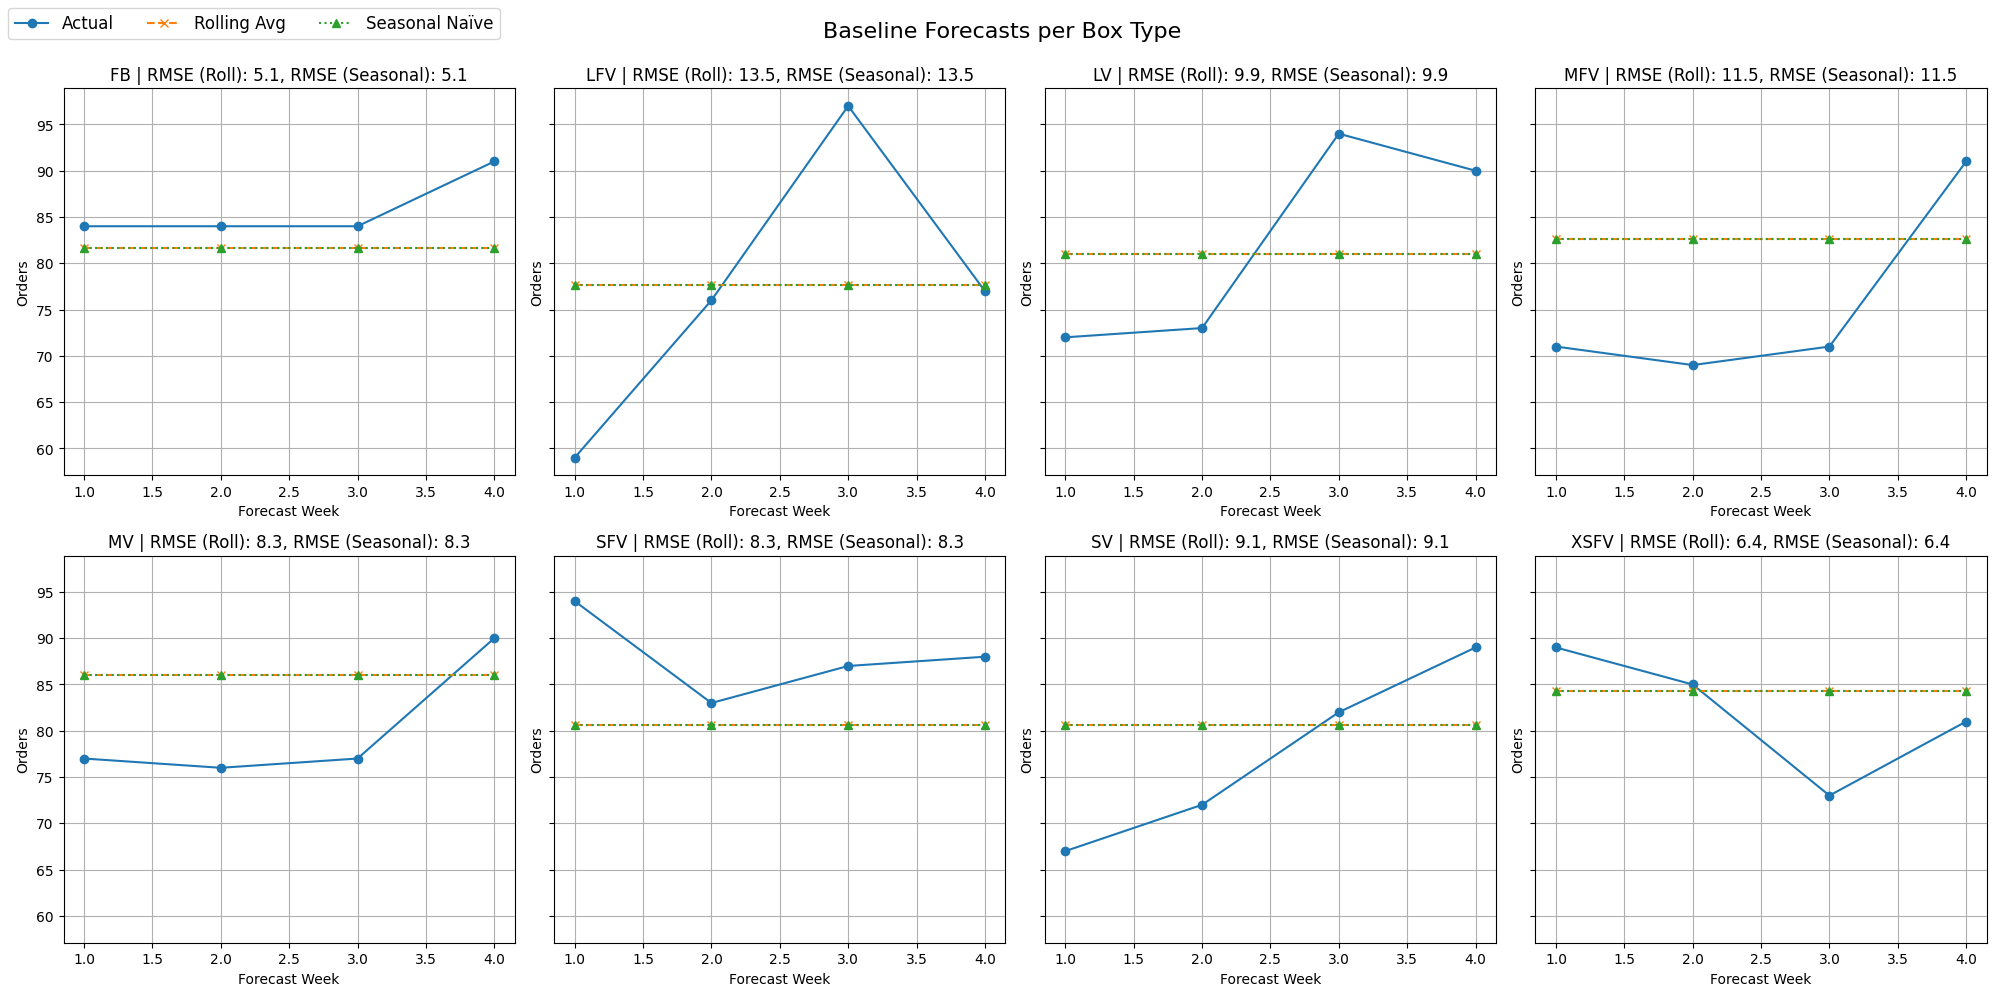

In [4]:
# Forecasting horizon
FORECAST_HORIZON = 4

# Store results
baseline_results = {}

# Forecast per box type
for box, group in df.groupby("box_type"):
    group = group.sort_values("week").copy()
    past_orders = group["box_orders"].iloc[:-FORECAST_HORIZON]

    # Rolling average (last 3 weeks)
    rolling_mean = past_orders.rolling(window=3).mean().iloc[-1]
    rolling_forecast = [rolling_mean] * FORECAST_HORIZON

    # Seasonal naive: same week last year
    last_year_indices = [-FORECAST_HORIZON - 52 + i for i in range(FORECAST_HORIZON)]
    if all(idx >= 0 for idx in last_year_indices):
        seasonal_naive_forecast = group["box_orders"].iloc[last_year_indices].tolist()
    else:
        seasonal_naive_forecast = rolling_forecast  # fallback

    # Actuals
    actual = group["box_orders"].iloc[-FORECAST_HORIZON:].tolist()

    # Metrics
    rmse_roll = np.sqrt(mean_squared_error(actual, rolling_forecast))
    mae_roll = mean_absolute_error(actual, rolling_forecast)

    rmse_seasonal = np.sqrt(mean_squared_error(actual, seasonal_naive_forecast))
    mae_seasonal = mean_absolute_error(actual, seasonal_naive_forecast)

    # Save
    baseline_results[box] = {
        "actual": actual,
        "rolling_forecast": rolling_forecast,
        "seasonal_naive": seasonal_naive_forecast,
        "rmse_roll": rmse_roll,
        "mae_roll": mae_roll,
        "rmse_seasonal": rmse_seasonal,
        "mae_seasonal": mae_seasonal,
    }

# Plotting all box types
fig, axes = plt.subplots(2, 4, figsize=(20, 10), sharey=True)
axes = axes.flatten()

for idx, (box, res) in enumerate(baseline_results.items()):
    ax = axes[idx]
    x = range(1, FORECAST_HORIZON + 1)

    ax.plot(x, res["actual"], marker="o", label="Actual")
    ax.plot(x, res["rolling_forecast"], marker="x", linestyle="--", label="Rolling Avg")
    ax.plot(x, res["seasonal_naive"], marker="^", linestyle=":", label="Seasonal Naïve")

    ax.set_title(
        f"{box} | RMSE (Roll): {res['rmse_roll']:.1f}, RMSE (Seasonal): {res['rmse_seasonal']:.1f}"
    )
    ax.set_xlabel("Forecast Week")
    ax.set_ylabel("Orders")
    ax.grid(True)

# One shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper left", ncol=3, fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle("Baseline Forecasts per Box Type", fontsize=16)
plt.show()


##### Observations
- Across most box types, the **rolling average baseline performs reasonably well**, especially for stable boxes like `LV` and `FB`.
- Seasonal naïve often underperforms due to limited data (only one full year) and inconsistent seasonality across box types.
- Boxes with higher volatility (e.g., `LFV`, `MV`) exhibit higher baseline error, emphasizing the need for more informed models.

These baselines give us a clear benchmark: any advanced model must outperform these methods to be justifiable.

##### Implication for Modeling
- Rolling average will be used as a sanity check throughout model development.
- Seasonal naïve may inform adjustments in more seasonal box types if clearer yearly cycles emerge with more data.

## 4. Box Type Share Model

In [49]:
# Ensure datetime type
df_model["week"] = pd.to_datetime(df_model["week"])
df_model["total_orders"] = df_model.groupby("week")["box_orders"].transform("sum")
df_model["box_share"] = df_model["box_orders"] / df_model["total_orders"]

# Compute total_orders per week
df_total = (
    df_model.groupby("week")
    .agg(
        total_orders=("box_orders", "sum"),
        weekly_subscribers=("weekly_subscribers", "first"),
        fortnightly_subscribers=("fortnightly_subscribers", "first"),
        weekly_subscribers_lag_1=("weekly_subscribers_lag_1", "first"),
        weekly_subscribers_lag_2=("weekly_subscribers_lag_2", "first"),
        is_marketing_week=("is_marketing_week", "first"),
        holiday_week=("holiday_week", "first"),
        is_event_week=("is_event_week", "first"),
        week_sin=("week_sin", "first"),
        week_cos=("week_cos", "first")
    )
).reset_index()

# Handle any NA due to lags/rolling
df_total = df_total.fillna(method="ffill").fillna(method="bfill")

# Split into train/holdout (last 4 weeks = holdout)
df_total = df_total.sort_values("week").reset_index(drop=True)
holdout_weeks = df_total["week"].iloc[-4:]

df_total_train = df_total[~df_total["week"].isin(holdout_weeks)]
df_total_test = df_total[df_total["week"].isin(holdout_weeks)]

X_total_train = df_total_train.drop(columns=["week", "total_orders"])
y_total_train = df_total_train["total_orders"]


/var/folders/q7/ty_v1f4s33q7z2w_mtgghhfc0000gq/T/ipykernel_76557/1904027186.py:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_total = df_total.fillna(method="ffill").fillna(method="bfill")


In [50]:
# --- STEP 4: Fit total orders model ---
total_model = lgb.LGBMRegressor(n_estimators=100, random_state=42)
total_model.fit(X_total_train, y_total_train)

# --- STEP 5: Fit share model per box_type using same weeks ---
share_features = ["week_sin", "week_cos", "is_marketing_week", "holiday_week"]
share_models = {}

# Filter df_model to exclude holdout weeks
df_model_train = df_model[~df_model["week"].isin(holdout_weeks)]

for box in config.BOX_TYPES:
    df_box = df_model_train[df_model_train["box_type"] == box].dropna(subset=["box_share"] + share_features)
    X = df_box[share_features]
    y = df_box["box_share"]

    model = lgb.LGBMRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)

    share_models[box] = {
        "model": model,
        "train_rows": len(X),
        "train_weeks": df_box["week"].nunique()
    }


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 95
[LightGBM] [Info] Number of data points in the train set: 46, number of used features: 6
[LightGBM] [Info] Start training from score 647.304348
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

  box_type       rmse        mae  rmse_baseline  mae_baseline  mean_actual  \
0       FB   8.129172   7.832727       3.958114      3.333333    85.750000   
1      LFV  13.642573  12.546205      13.092619      9.583333    77.250000   
2       LV   8.592074   8.260961      11.565034     10.250000    82.250000   
3      MFV  13.038242  12.549426      12.776932     11.416667    75.500000   
4       MV   4.691806   4.036467      10.428327     10.083333    80.000000   
5      SFV   9.005143   6.239718       6.685390      3.583333    88.000000   
6       SV   5.621805   5.437677      11.101802      9.916667    77.500000   
7     XSFV   8.669234   7.102119       6.525591      4.916667    82.000000   
0       FB   7.504783   5.973629       8.892118      7.023256    79.760870   
1      LFV   9.016346   7.418570      11.699842      8.937984    81.086957   
2       LV   6.581556   4.993749       8.090253      6.356589    82.826087   
3      MFV   8.283611   6.884352      11.114625      9.348837   

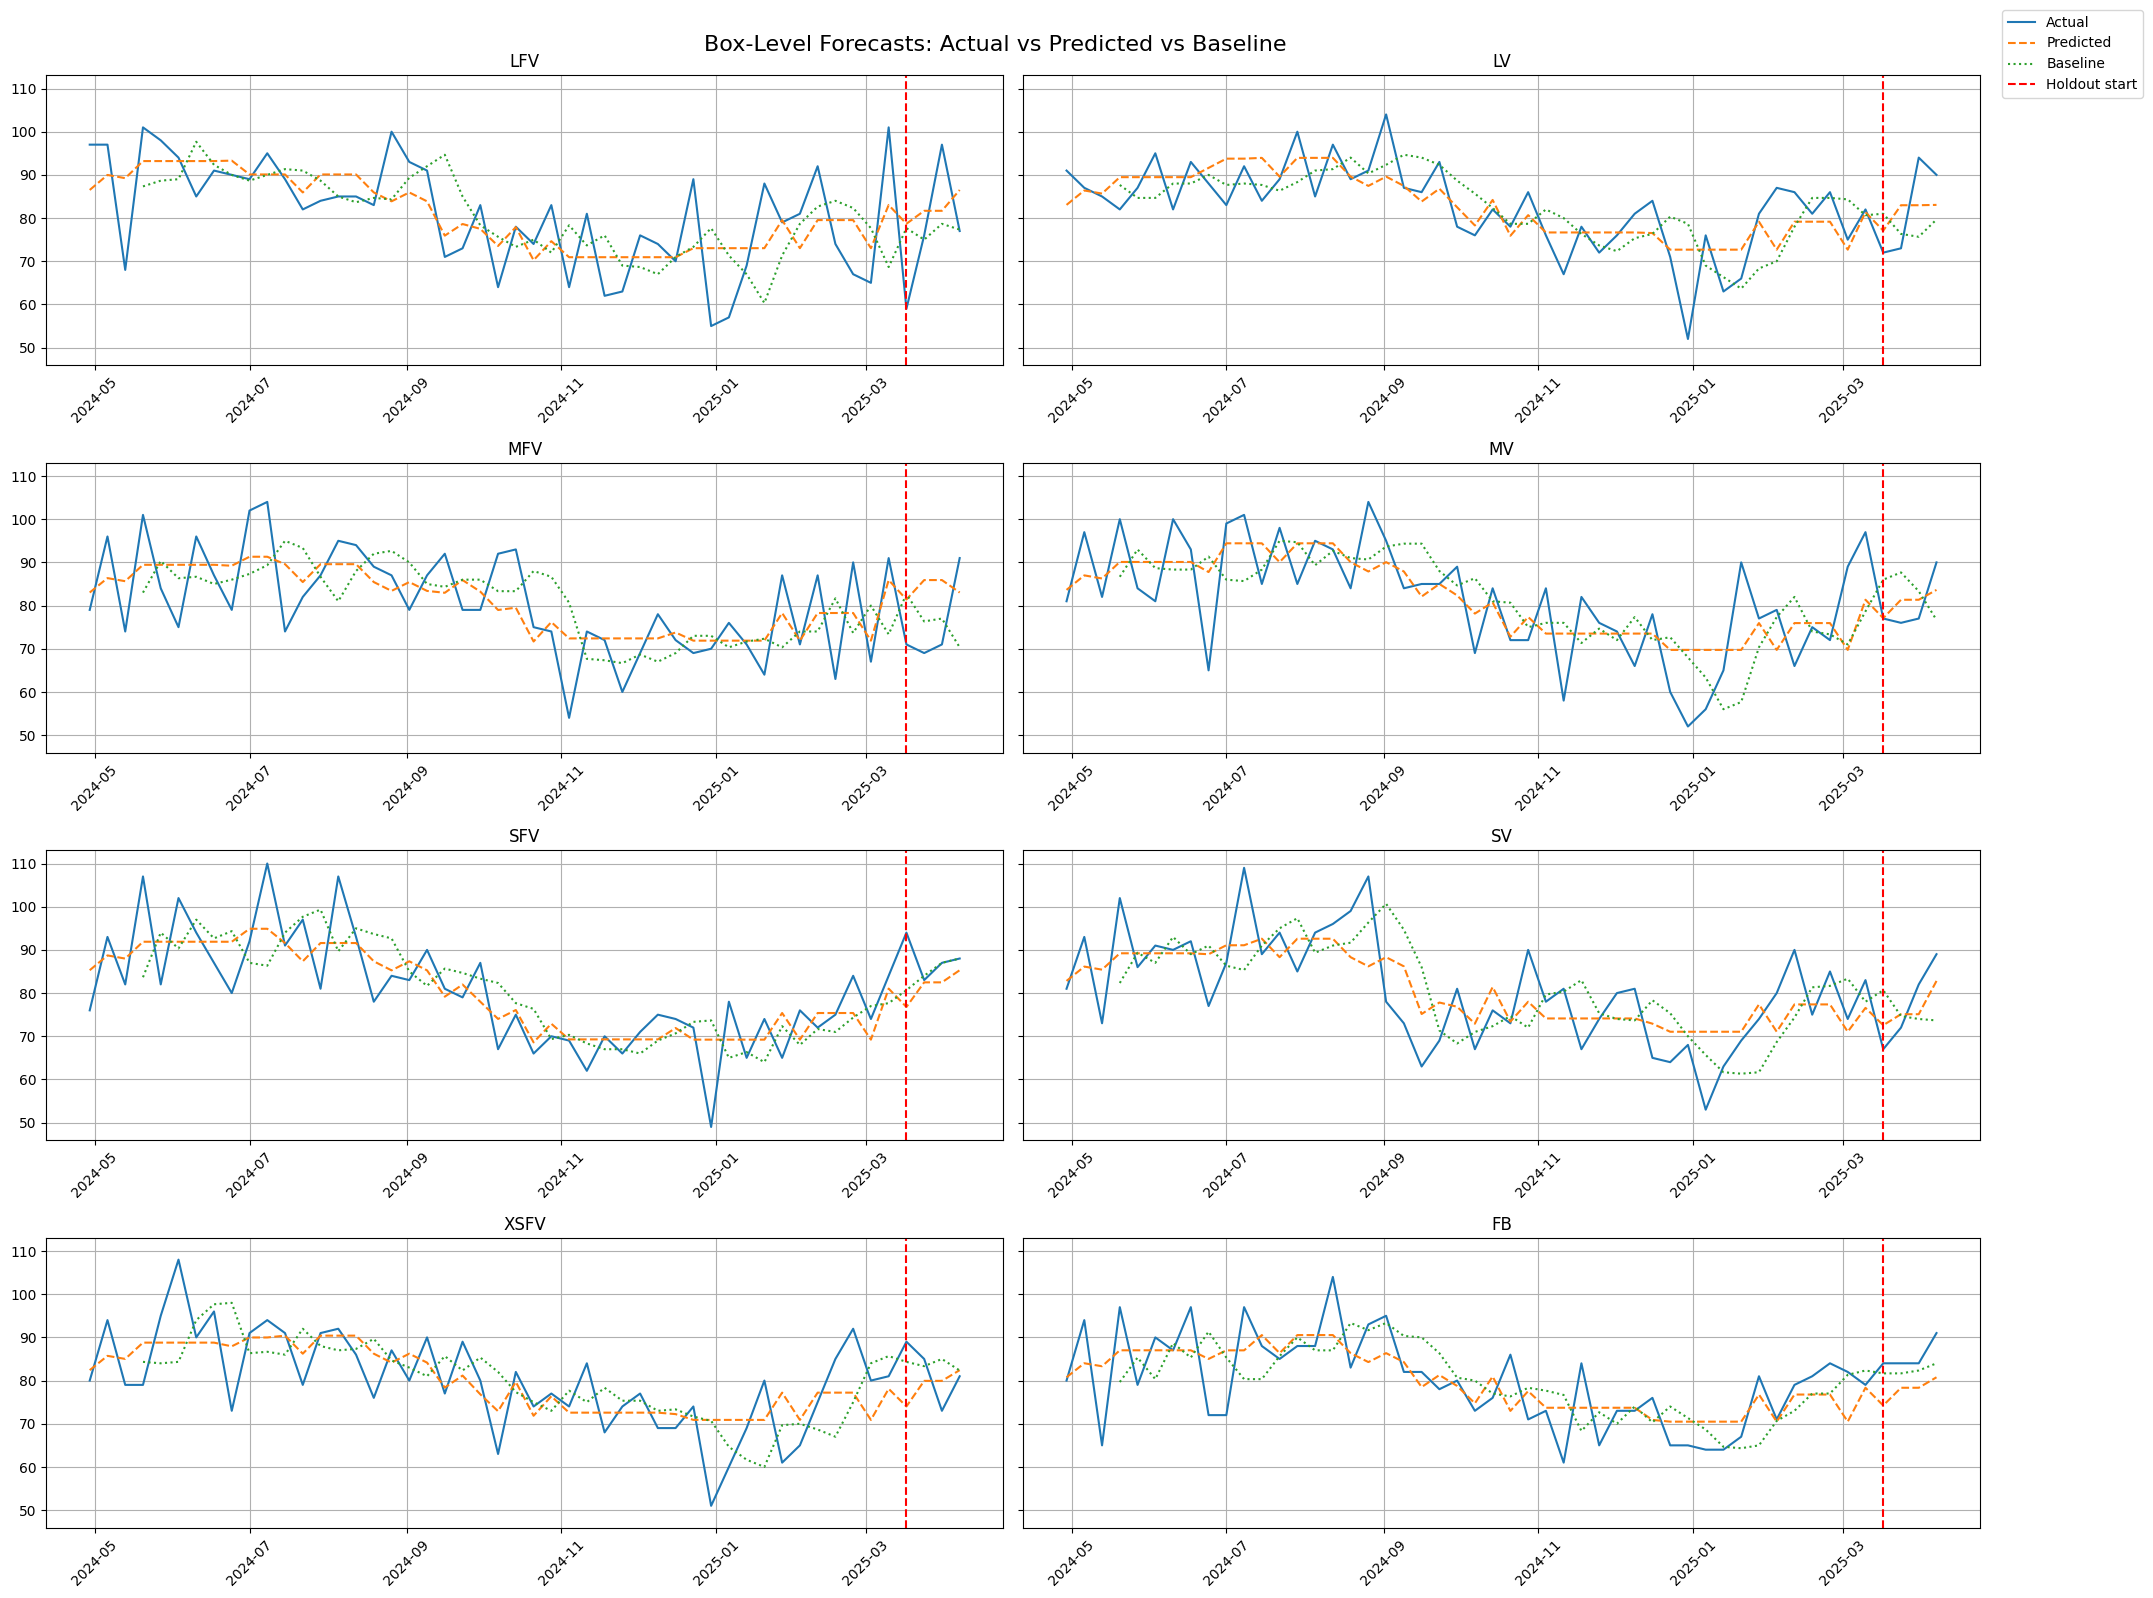

In [51]:
# Predict total orders
df_total["total_pred"] = total_model.predict(df_total.drop(columns=["week", "total_orders"]))

# Split again for alignment
df_total_train = df_total[~df_total["week"].isin(holdout_weeks)]
df_total_test = df_total[df_total["week"].isin(holdout_weeks)]

# Add predictions to df_model
df_model["total_pred"] = df_model["week"].map(df_total.set_index("week")["total_pred"])

all_preds = []

for box in config.BOX_TYPES:
    df_box = df_model[df_model["box_type"] == box].copy()
    df_box = df_box.dropna(subset=share_features + ["box_orders", "total_pred"])

    model = share_models[box]["model"]
    X_share = df_box[share_features]
    df_box["predicted_share"] = model.predict(X_share)

    df_box["predicted_box_orders"] = df_box["predicted_share"] * df_box["total_pred"]
    df_box["squared_error"] = (df_box["box_orders"] - df_box["predicted_box_orders"]) ** 2
    df_box["abs_error"] = np.abs(df_box["box_orders"] - df_box["predicted_box_orders"])

    # Baseline (rolling mean of last 3 obs per box)
    df_box = df_box.sort_values("week")
    df_box["rolling_baseline"] = df_box["box_orders"].shift(1).rolling(window=3).mean()
    df_box["baseline_squared_error"] = (df_box["box_orders"] - df_box["rolling_baseline"]) ** 2
    df_box["baseline_abs_error"] = np.abs(df_box["box_orders"] - df_box["rolling_baseline"])

    all_preds.append(df_box)

df_preds_all = pd.concat(all_preds)

def compute_metrics(df, split_label):
    return (
        df.groupby("box_type")
        .agg(
            rmse=("squared_error", lambda x: np.sqrt(np.mean(x))),
            mae=("abs_error", "mean"),
            rmse_baseline=("baseline_squared_error", lambda x: np.sqrt(np.mean(x))),
            mae_baseline=("baseline_abs_error", "mean"),
            mean_actual=("box_orders", "mean")
        )
        .assign(
            mape=lambda d: 100 * d["mae"] / d["mean_actual"],
            split=split_label
        )
        .reset_index()
    )

df_preds_train = df_preds_all[~df_preds_all["week"].isin(holdout_weeks)]
df_preds_test = df_preds_all[df_preds_all["week"].isin(holdout_weeks)]

metrics_train = compute_metrics(df_preds_train, "train")
metrics_test = compute_metrics(df_preds_test, "test")

metrics_summary = pd.concat([metrics_train, metrics_test])
print(metrics_summary.sort_values(["split", "box_type"]))


fig, axes = plt.subplots(4, 2, figsize=(20, 16), sharey=True)
axes = axes.flatten()

for i, box in enumerate(config.BOX_TYPES):
    df_box = df_preds_all[df_preds_all["box_type"] == box]
    ax = axes[i]
    ax.plot(df_box["week"], df_box["box_orders"], label="Actual")
    ax.plot(df_box["week"], df_box["predicted_box_orders"], label="Predicted", linestyle="--")
    ax.plot(df_box["week"], df_box["rolling_baseline"], label="Baseline", linestyle=":")
    ax.axvline(holdout_weeks.min(), color="red", linestyle="--", label="Holdout start" if i == 0 else None)
    ax.set_title(box)
    ax.tick_params(axis="x", rotation=45)
    ax.grid(True)

fig.suptitle("Box-Level Forecasts: Actual vs Predicted vs Baseline", fontsize=16)
# Extract legend handles from the first subplot only
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


#### Key Takeaways

- **Model generally outperforms baseline** on both training and test sets.
- **Test MAPE < 10%** for most box types:
  - `MV`: **5.0%**
  - `SFV`: **7.1%**
  - `FB`: **9.1%**
  - `LV`: **10.0%**
- **Model > Baseline in RMSE** across most types on test data, indicating strong generalisation.
- **Baseline still competitive** for a few boxes (e.g. `LFV`, `MFV`) – these may benefit from:
  - More tailored features
  - Uplift correction layers (e.g., marketing/holiday effects)
  - Longer historical training windows


## 5. Adjustment Layer (Uplift/Dampeners)

In [52]:
df_preds_all.head()

,week,box_type,box_orders,is_marketing_week,holiday_week,weekly_subscribers,fortnightly_subscribers,weekly_subscribers_lag_1,weekly_subscribers_lag_2,box_orders_lag_1,box_orders_lag_2,box_orders_rollmean,box_orders_rollstd,is_event_week,weekofyear,week_sin,week_cos,marketing_x_box,holiday_x_box,box_orders_volatility,total_orders,box_share,total_pred,predicted_share,predicted_box_orders,squared_error,abs_error,rolling_baseline,baseline_squared_error,baseline_abs_error
16,2024-04-29,LFV,97,0,0,501,173.0,453.0,483.0,64.0,79.0,80.000000,16.522712,0,18,0.822984,-0.568065,LFV_MKT_0,LFV_HOL_0,16.522712,665,0.145865,666.597606,0.129774,86.507085,110.101275,10.492915,NaN,NaN,NaN
24,2024-05-06,LFV,97,1,0,556,170.0,501.0,453.0,97.0,64.0,86.000000,19.052559,1,19,0.748511,-0.663123,LFV_MKT_1,LFV_HOL_0,19.052559,751,0.129161,693.395327,0.129774,89.984734,49.213958,7.015266,NaN,NaN,NaN
32,2024-05-13,LFV,68,0,1,546,174.0,556.0,501.0,97.0,97.0,87.333333,16.743158,1,20,0.663123,-0.748511,LFV_MKT_0,LFV_HOL_1,16.743158,608,0.111842,687.638873,0.129774,89.237695,451.039705,21.237695,NaN,NaN,NaN
40,2024-05-20,LFV,101,1,0,510,179.0,546.0,556.0,68.0,97.0,88.666667,18.009257,1,21,0.568065,-0.822984,LFV_MKT_1,LFV_HOL_0,18.009257,769,0.131339,718.151391,0.129774,93.197429,60.880112,7.802571,87.333333,186.777778,13.666667
48,2024-05-27,LFV,98,0,0,544,168.0,510.0,546.0,101.0,68.0,89.000000,18.248288,0,22,0.464723,-0.885456,LFV_MKT_0,LFV_HOL_0,18.248288,695,0.141007,718.151391,0.129774,93.197429,23.064687,4.802571,88.666667,87.111111,9.333333


In [53]:
def calculate_event_uplift(df: pd.DataFrame) -> pd.DataFrame:
    """Estimate % uplift or dampening effect from events by box_type."""
    impacts = []

    for box in config.BOX_TYPES:
        df_box = df[df["box_type"] == box].copy()

        for col, label in [("is_marketing_week", "marketing"), ("holiday_week", "holiday")]:
            base = df_box[df_box[col] == 0]["box_orders"]
            event = df_box[df_box[col] == 1]["box_orders"]

            if len(base) >= 5 and len(event) >= 2:
                uplift = (event.mean() - base.mean()) / base.mean()
                impacts.append({"box_type": box, "event_type": label, "uplift": uplift})

    return pd.DataFrame(impacts)

def apply_adjustment_layer(df: pd.DataFrame, uplift_df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    for _, row in uplift_df.iterrows():
        mask = (df["box_type"] == row["box_type"])

        if row["event_type"] == "marketing":
            df.loc[mask & (df["is_marketing_week"] == 1), "adjusted_prediction"] = \
                df["predicted_box_orders"] * (1 + row["uplift"])

        elif row["event_type"] == "holiday":
            df.loc[mask & (df["holiday_week"] == 1), "adjusted_prediction"] = \
                df["predicted_box_orders"] * (1 + row["uplift"])

    # For all other rows, keep original prediction
    df["adjusted_prediction"] = df["adjusted_prediction"].fillna(df["predicted_box_orders"])
    return df


def compute_adjusted_metrics(df: pd.DataFrame, split_label: str) -> pd.DataFrame:
    return (
        df.groupby("box_type")
        .agg(
            rmse=("squared_error", lambda x: np.sqrt(np.mean(x))),
            mae=("abs_error", "mean"),
            rmse_adj=("adjusted_squared_error", lambda x: np.sqrt(np.mean(x))),
            mae_adj=("adjusted_abs_error", "mean"),
        )
        .assign(split=split_label)
        .reset_index()
    )


# Learn historical impacts
uplift_df = calculate_event_uplift(df_preds_all)
# Apply adjustments
df_preds_all = apply_adjustment_layer(df_preds_all, uplift_df)
# Evaluate
df_preds_all["adjusted_squared_error"] = (df_preds_all["box_orders"] - df_preds_all["adjusted_prediction"])**2
df_preds_all["adjusted_abs_error"] = np.abs(df_preds_all["box_orders"] - df_preds_all["adjusted_prediction"])

,box_type,rmse_model,mae_model,rmse_baseline,mae_baseline,rmse_adjusted,mae_adjusted,mean_actual,mape_model,mape_adjusted
0,FB,8.129172,7.832727,3.958114,3.333333,7.780609,7.203222,85.75,9.134376,8.400258
1,LFV,13.642573,12.546205,13.092619,9.583333,11.333723,9.211218,77.25,16.241042,11.923907
2,LV,8.592074,8.260961,11.565034,10.250000,7.334972,7.114514,82.25,10.043722,8.649864
3,MFV,13.038242,12.549426,12.776932,11.416667,16.438319,15.063237,75.50,16.621756,19.951308
4,MV,4.691806,4.036467,10.428327,10.083333,7.960955,6.344252,80.00,5.045584,7.930315
5,SFV,9.005143,6.239718,6.685390,3.583333,8.794794,5.692930,88.00,7.090589,6.469239
6,SV,5.621805,5.437677,11.101802,9.916667,5.263633,5.126904,77.50,7.016358,6.615360
7,XSFV,8.669234,7.102119,6.525591,4.916667,8.724998,7.170706,82.00,8.661121,8.744763


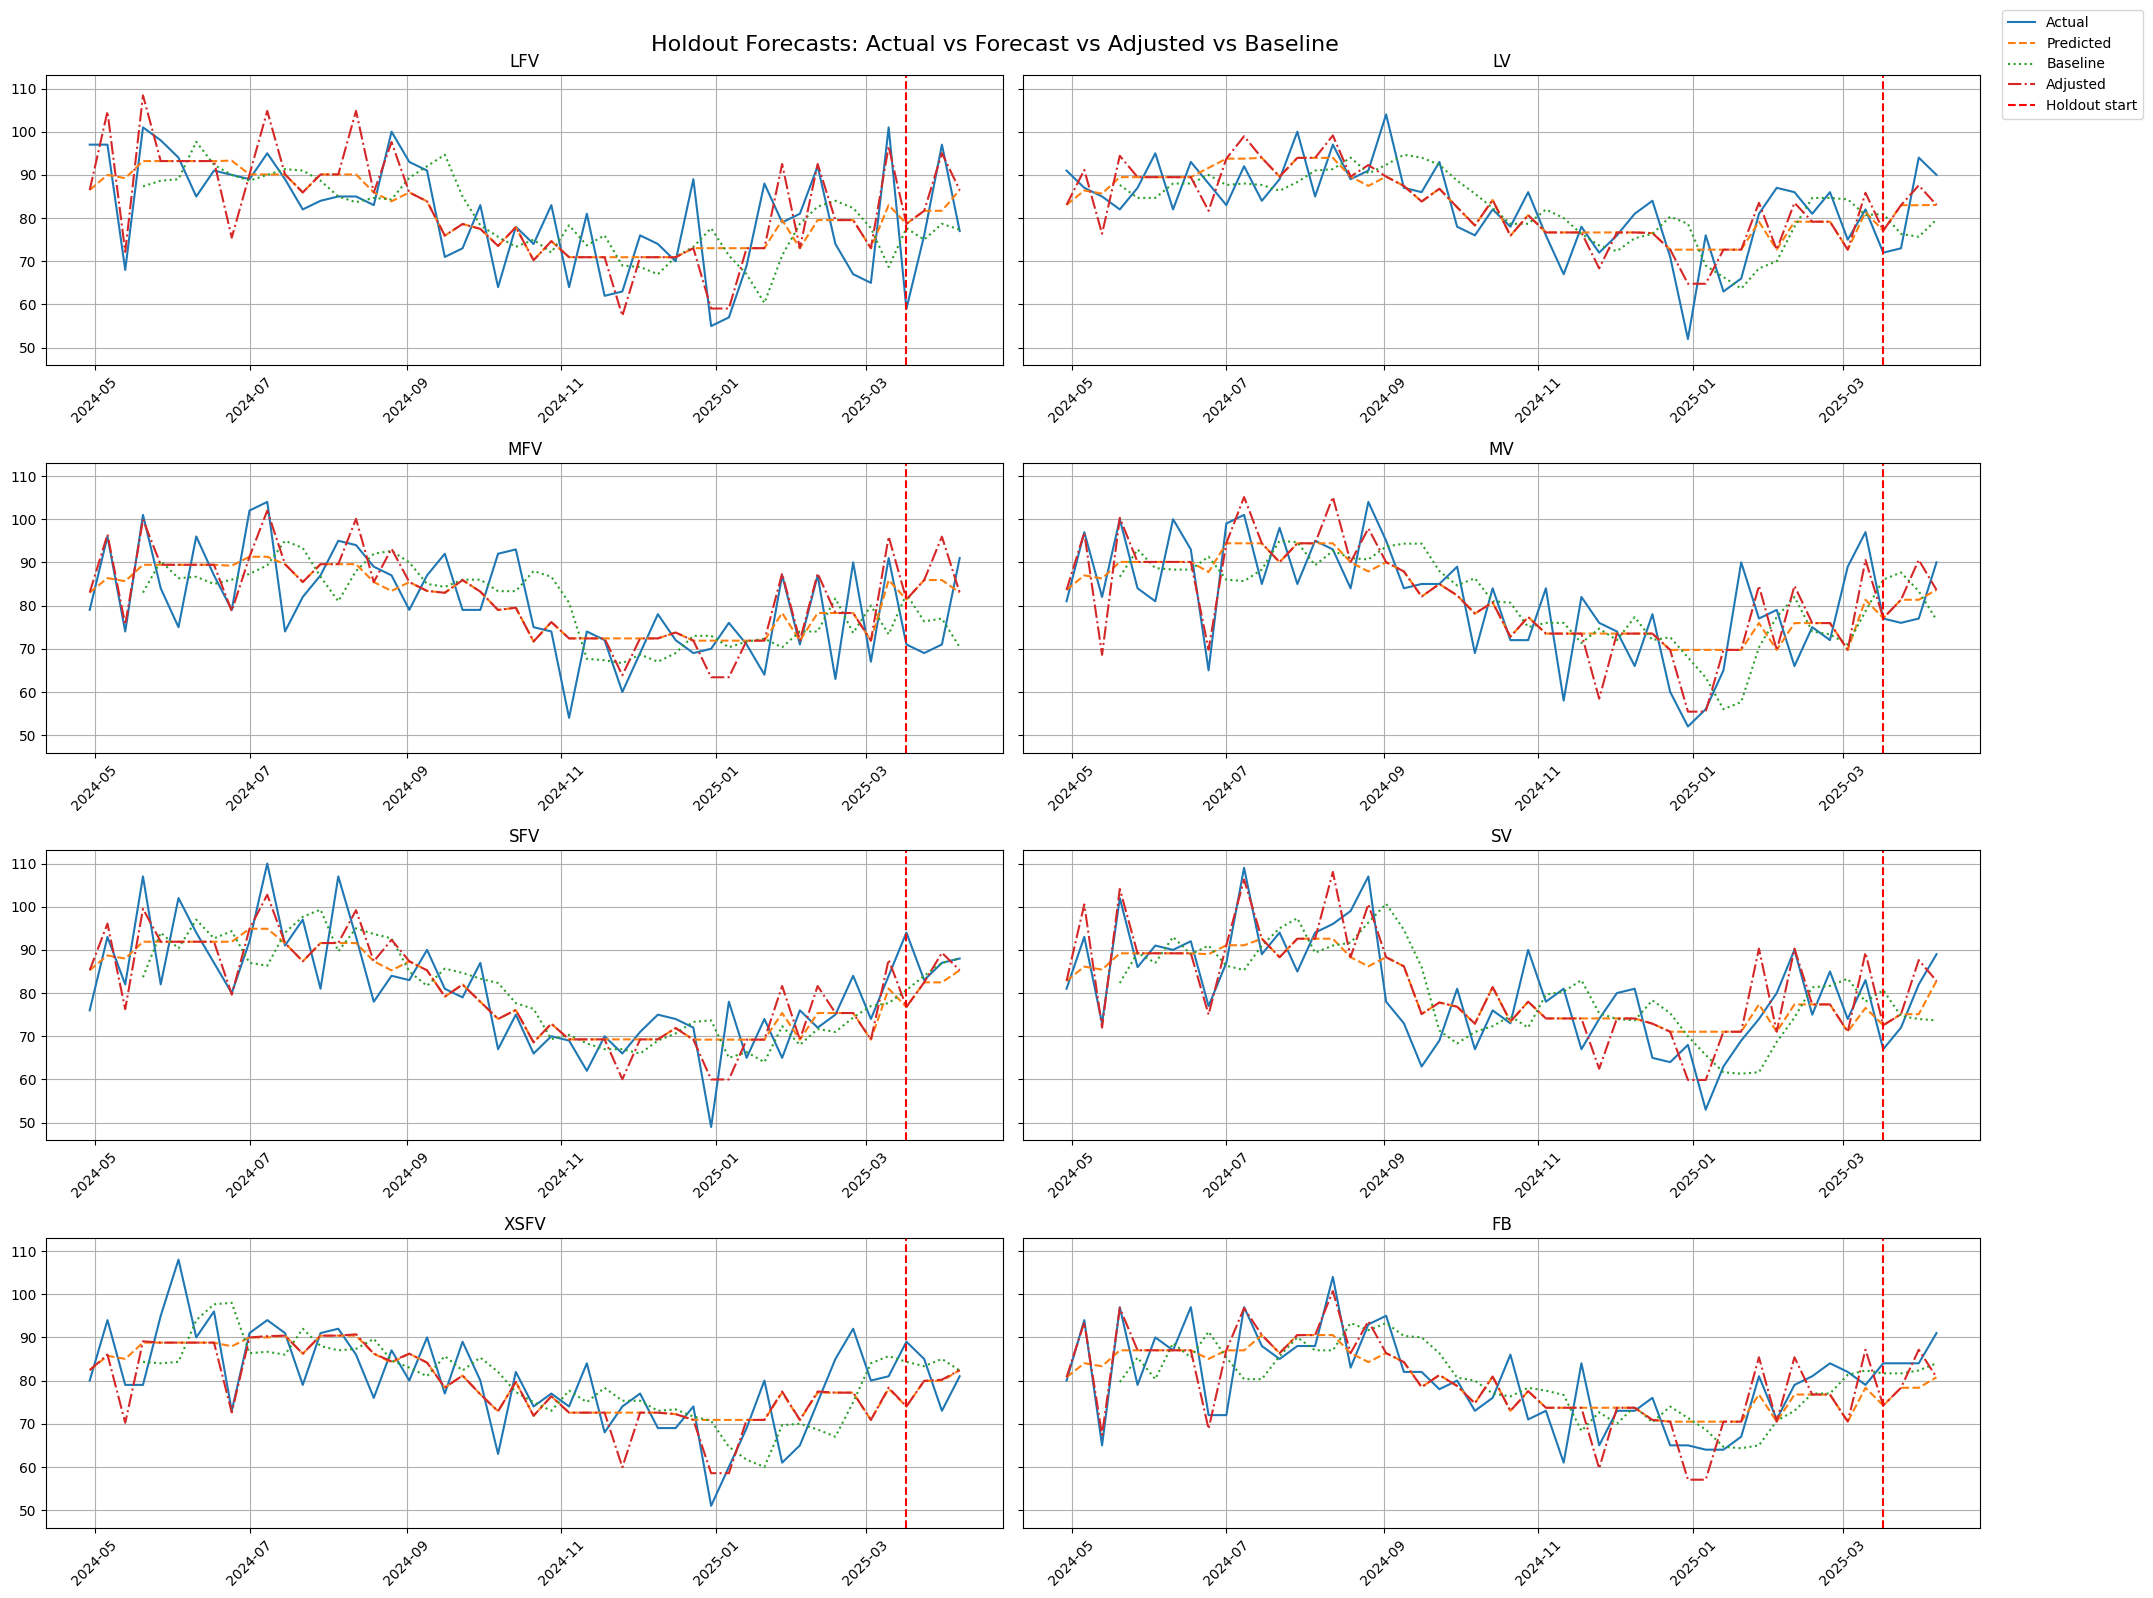

In [54]:
# Compute Metrics
df_holdout = df_preds_all[df_preds_all["week"].isin(holdout_weeks)].copy()

adjusted_metrics = (
    df_holdout.groupby("box_type")
    .agg(
        rmse_model=("squared_error", lambda x: np.sqrt(np.mean(x))),
        mae_model=("abs_error", "mean"),
        rmse_baseline=("baseline_squared_error", lambda x: np.sqrt(np.mean(x))),
        mae_baseline=("baseline_abs_error", "mean"),
        rmse_adjusted=("adjusted_squared_error", lambda x: np.sqrt(np.mean(x))),
        mae_adjusted=("adjusted_abs_error", "mean"),
        mean_actual=("box_orders", "mean")
    )
    .assign(
        mape_model=lambda d: 100 * d["mae_model"] / d["mean_actual"],
        mape_adjusted=lambda d: 100 * d["mae_adjusted"] / d["mean_actual"]
    )
    .reset_index()
)

display(adjusted_metrics.sort_values("box_type"))

fig, axes = plt.subplots(4, 2, figsize=(20, 16), sharey=True)
axes = axes.flatten()

for i, box in enumerate(config.BOX_TYPES):
    df_box = df_preds_all[df_preds_all["box_type"] == box]
    ax = axes[i]
    ax.plot(df_box["week"], df_box["box_orders"], label="Actual")
    ax.plot(df_box["week"], df_box["predicted_box_orders"], label="Predicted", linestyle="--")
    ax.plot(df_box["week"], df_box["rolling_baseline"], label="Baseline", linestyle=":")
    ax.plot(df_box["week"], df_box["adjusted_prediction"], label="Adjusted",  linestyle="-.")
    
    ax.axvline(holdout_weeks.min(), color="red", linestyle="--", label="Holdout start" if i == 0 else None)
    ax.set_title(box)
    ax.tick_params(axis="x", rotation=45)
    ax.grid(True)

fig.suptitle("Holdout Forecasts: Actual vs Forecast vs Adjusted vs Baseline", fontsize=16)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


##### Adjustment Layer Evaluation

**Purpose**
This layer applies post-prediction adjustment factors to account for systematic uplift or dampening effects from known events — specifically marketing campaigns and holiday weeks — which aren't always fully captured by the primary models.

**Visual Interpretation**

- **Adjustment improves accuracy** in **5 out of 8** box types on RMSE and MAPE.
- Notable gains seen in:
  - **LFV**: MAPE drops from 16.2% → 11.9%
  - **LV**: MAPE drops from 10.0% → 8.6%
- **SV** and **SFV** also benefit from marginal improvements.

However:
- **MFV** and **MV** worsened after adjustment, likely due to:
  - Overcorrection from uplift/downweighting
  - Event interaction effects not generalizing well
- **FB** slightly improved, but was already stable

**Interpretation**

- The adjustment layer is helpful where holiday/marketing effects are historically **predictable and directional**.
- It does **not help (and may hurt)** in noisy or less responsive box types like MFV or MV.
- A better strategy could be **box-type-specific uplift thresholds** or **model-based treatment effects** (future stretch goal).

**Recommendation**

- **Keep this adjustment logic** in the forecasting pipeline.
- Consider exposing the uplift/dampening effects as **parameters** for tuning or rule-based overrides per box type.
- Future enhancement: Learn these adjustment weights from the model using **causal uplift modeling** or **post-hoc regression residual analysis**.

## 6. Next Steps

I didn't have time to finish the final layer I wanted to add: Confidence Intervals. This layer would take the adjusted predictions and give a high/low confidence interval around the forecast itself.